In [1]:
from scipy.stats import pearsonr, spearmanr, wilcoxon

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import stan
figsize = stan.figsize
fontsize = stan.fontsize
dpi = stan.dpi

## Load ST datasets

In [2]:
id_list = {
    'CID4290': 'ER_1',
    'CID4535': 'ER_2',
    'CID44971': 'TNBC_4',
    'CID4465': 'TNBC_3'
}
sample_list = id_list.keys()

adatas = dict()
for sample in sample_list:
    adatas[sample] = sc.read_h5ad('outputs_stan/adata_Breast_Wu_{}.h5ad'.format(sample))
    adatas[sample].obsm['tfa_ridge'] = pd.read_csv(f'outputs_stan/adata_Breast_Wu_{sample}_tfa_ridge.csv', index_col=0)
    adatas[sample].obs['pred_cor_ridge'] = pd.read_csv(f'outputs_stan/adata_Breast_Wu_{sample}_pred_cor_ridge.csv', index_col=0)

adatas_tfa = dict()
for sample in sample_list:
    adatas_tfa[sample] = stan.get_activity(adatas[sample], key='tfa_stan') 
    sc.pp.scale(adatas_tfa[sample])

## Load scRNA datasets

In [3]:
adata_sc = sc.read_h5ad("results_breast/scRNA.h5ad")
genes = pd.read_excel("results_breast/41467_2021_26271_MOESM16_ESM.xlsx", header=None)[0].to_list()
genes_for_stsc = np.intersect1d(adata_sc.var_names, genes)

adatas_sc = dict()
adatas_sc['CID4290'] = adata_sc[adata_sc.obs["orig.ident"] == 'CID4290A', genes_for_stsc]
adatas_sc['CID4535'] = adata_sc[adata_sc.obs["orig.ident"] == 'CID4535', genes_for_stsc]
adatas_sc['CID4465'] = adata_sc[adata_sc.obs["orig.ident"] == 'CID4465', genes_for_stsc]
adatas_sc['CID44971'] = adata_sc[adata_sc.obs["orig.ident"] == 'CID44971', genes_for_stsc]
# del adata_sc

adatas_sc_tfa = dict()
for sample in sample_list:
    adatas_sc[sample].obsm['tfa_ridge'] = pd.read_csv(f'results_breast/scran_ridge_v3/adata_{sample}_tfa_ridge.csv', index_col=0)
    adatas_sc[sample].obs['pred_cor_ridge'] = pd.read_csv(f'results_breast/scran_ridge_v3/adata_{sample}_pred_cor_ridge.csv', index_col=0)
    adatas_sc_tfa[sample] = stan.get_activity(adatas_sc[sample], key='tfa_ridge')
    sc.pp.scale(adatas_sc_tfa[sample])

In [4]:
adatas_sc = dict()
for sample in sample_list:
    adatas_sc[sample] = sc.read_h5ad(f"results_breast/scran_ridge_v2/adata_Breast_Wu_{sample}.h5ad")

adatas_sc_tfa = dict()
for sample in sample_list:
    adatas_sc_tfa[sample] = stan.get_activity(adatas_sc[sample], key='tfa_ridge')
    sc.pp.scale(adatas_sc_tfa[sample])

In [5]:
for sample in sample_list:
    df = pd.read_csv('results_breast/celltype_major/{}.csv'.format(sample), index_col=0)
    cells = np.intersect1d(adatas[sample].obs.index, df.index)
    
    df = df.loc[cells,:]
    adatas[sample] = adatas[sample][cells, :]
    adatas_tfa[sample] = adatas_tfa[sample][cells, :]
    
    adatas[sample].obsm['celltype'] = df
    adatas_tfa[sample].obsm['celltype'] = df

## Computing TF activity scores by cell type

In [6]:
sc_scores = dict()
st_scores = dict()
st_scores_ridge = dict()

for sample in ["CID4290", "CID4465", "CID4535", "CID44971"]:
    print("-"*20, sample, "-"*20)

    adata_st = adatas_tfa[sample]
    adata_sc = adatas_sc_tfa[sample]

    var_names = np.intersect1d(adata_sc.var_names,adata_st.var_names)
    adata_sc = adata_sc[:,var_names]
    adata_st = adata_st[:,var_names]

    cts = np.intersect1d(adata_st.obsm['celltype'].columns, adata_sc.obs['celltype_major'].unique())

    adata_st.varm['ct_scores'] = pd.DataFrame(
        np.linalg.pinv(adata_st.obsm['celltype']).dot(adata_st.to_df('tfa_stan')).T,
        index=adata_st.var_names,
        columns=adata_st.obsm['celltype'].columns
    )
    adata_st.varm['ct_scores_ridge'] = pd.DataFrame(
        np.linalg.pinv(adata_st.obsm['celltype']).dot(adata_st.to_df('tfa_ridge')).T,
        index=adata_st.var_names,
        columns=adata_st.obsm['celltype'].columns
    )
    adata_sc.varm['ct_scores'] = adata_sc.to_df('tfa_ridge').groupby(adata_sc.obs['celltype_major']).mean().T

    print(pd.DataFrame({ "sc vs stl":
                       {ct: round(spearmanr(adata_sc.varm['ct_scores'][ct], adata_st.varm['ct_scores_ridge'][ct])[0],2)
                        for ct in cts},
                   "sc vs stan":{ct:  round(spearmanr(adata_sc.varm['ct_scores'][ct], adata_st.varm['ct_scores'][ct])[0],2)
                                 for ct in cts}}))


    for ct in cts:
        if sc_scores.get(ct) is None:
            sc_scores[ct]=dict()
        if st_scores.get(ct) is None:
            st_scores[ct]=dict()
        if st_scores_ridge.get(ct) is None:
            st_scores_ridge[ct]=dict()
        sc_scores[ct][sample] = adata_sc.varm['ct_scores'][ct]
        st_scores[ct][sample] = adata_st.varm['ct_scores'][ct]
        st_scores_ridge[ct][sample] = adata_st.varm['ct_scores_ridge'][ct]


-------------------- CID4290 --------------------
                   sc vs stl  sc vs stan
B-cells                -0.00        0.11
CAFs                   -0.06        0.26
Cancer Epithelial       0.17        0.38
Endothelial            -0.12        0.48
Myeloid                -0.05        0.08
Normal Epithelial       0.13        0.14
PVL                    -0.01        0.06
T-cells                -0.00        0.29
-------------------- CID4465 --------------------
                   sc vs stl  sc vs stan
B-cells                 0.14        0.18
CAFs                    0.01        0.20
Cancer Epithelial       0.12        0.46
Endothelial             0.17        0.22
Myeloid                 0.13        0.26
Normal Epithelial      -0.03       -0.15
PVL                    -0.01        0.16
Plasmablasts           -0.11       -0.15
T-cells                 0.08        0.26
-------------------- CID4535 --------------------
                   sc vs stl  sc vs stan
B-cells                 0.01  

In [7]:
st_scores_list = dict()
sc_scores_list = dict()
st_scores_ridge_list = dict()
for sample in ["CID4290", "CID4465", "CID4535", "CID44971"]:
    df1 = pd.DataFrame([st_scores[x].get(sample) for x in st_scores.keys() if st_scores[x].get(sample) is not None]).T
    df2 = pd.DataFrame([sc_scores[x].get(sample) for x in sc_scores.keys() if sc_scores[x].get(sample) is not None]).T 
    df3 = pd.DataFrame([st_scores_ridge[x].get(sample) for x in st_scores_ridge.keys() if st_scores_ridge[x].get(sample) is not None]).T
    
    st_scores_list[sample] = (df1-df1.mean())/df1.std()
    sc_scores_list[sample] = (df2-df2.mean())/df2.std()
    st_scores_ridge_list[sample] = (df3-df3.mean())/df3.std()

In [8]:
st_scores_list[sample]

,B-cells,CAFs,Cancer Epithelial,Endothelial,Myeloid,Normal Epithelial,PVL,T-cells,Plasmablasts
AHR,0.070413,-0.675872,-0.796531,-1.395445,-0.483172,1.281508,1.334292,-0.066795,-0.371111
AR,-0.529506,-0.266769,-0.156637,0.103322,-0.993249,0.502974,0.036569,1.023625,-0.216256
ARID3A,-1.788437,1.247022,-0.282591,0.260242,-0.167822,0.666592,-1.285910,-0.386124,0.688878
ARNT,0.041241,-0.419889,0.209575,-0.217422,-1.526499,0.916621,1.243505,-0.115769,-0.305686
ARNTL,0.292050,0.631239,-1.473449,-1.792794,0.116396,1.465983,1.095715,-1.102346,0.066273
...,...,...,...,...,...,...,...,...,...
ZNF250,-0.868884,-0.923731,-0.475193,-0.600121,-1.145438,1.914160,0.886693,-0.186538,-0.094591
ZNF263,0.020214,-0.443102,0.490522,0.486184,0.411625,-0.701490,1.067588,-0.571655,0.116475
ZNF281,0.576542,-2.087583,1.332272,0.549723,-0.305641,0.387660,0.388501,-1.725984,-0.441831
ZNF384,1.435286,-1.132175,0.778200,-0.071840,-0.131195,-0.460723,0.058043,-0.269045,-0.086353


In [9]:
sc_scores_list[sample]

,B-cells,CAFs,Cancer Epithelial,Endothelial,Myeloid,Normal Epithelial,PVL,T-cells,Plasmablasts
AHR,0.358547,0.210007,-1.116792,0.591047,-0.279425,-0.051604,0.155433,0.476093,0.047894
AR,-0.169599,0.217250,-0.450731,-0.521787,0.352955,-0.040167,-1.013415,0.172723,-0.253749
ARID3A,-1.693920,-0.507039,-0.440495,0.981158,0.212513,0.778821,-0.706708,0.177974,1.071332
ARNT,0.330577,0.798720,0.856858,0.432857,-0.218868,2.008623,0.558772,-1.424595,0.922913
ARNTL,0.374041,-0.442167,-1.098093,0.061487,-0.494999,-1.043588,-0.259302,1.172182,-0.725409
...,...,...,...,...,...,...,...,...,...
ZNF250,1.799742,-1.230841,0.499751,-1.828293,-1.250467,1.630727,-1.501462,0.012172,-0.051087
ZNF263,0.109423,-0.187633,0.581652,0.466748,1.044865,-0.080210,1.192585,-0.692586,1.961342
ZNF281,-1.190992,0.514852,2.176942,-0.284961,-0.768562,0.699189,1.433379,-1.103532,0.242666
ZNF384,0.920891,-0.895209,0.758889,-0.711591,-0.834303,-1.674140,-1.339297,0.786260,-0.716689


## Correlating samples

In [14]:
df_corr = pd.DataFrame(index=id_list.values(),
                       columns=st_scores.keys())
for sample in sample_list:
    st_scores_df = st_scores_list[sample]
    sc_scores_df = sc_scores_list[sample]
    for celltype in sc_scores_df.columns:
        x = st_scores_df[celltype]
        y = sc_scores_df[celltype]
        df_corr.loc[id_list[sample], celltype] = spearmanr(x, y, alternative='two-sided')[0]
        # df_corr.loc[id_list[sample], celltype] = pearsonr(x, y)[0]

In [15]:
df_corr = df_corr.fillna(0)
df_corr

,B-cells,CAFs,Cancer Epithelial,Endothelial,Myeloid,Normal Epithelial,PVL,T-cells,Plasmablasts
ER_1,0.109426,0.258441,0.382534,0.475583,0.075358,0.137615,0.055277,0.286616,0.000000
ER_2,-0.024213,0.223009,0.647876,0.499615,0.537540,0.176832,0.494006,0.393027,0.191982
TNBC_4,0.255215,0.197611,0.640107,0.230242,0.492059,0.305986,0.178246,0.205768,0.121565
TNBC_3,0.184010,0.204736,0.462213,0.218365,0.261315,-0.154754,0.160642,0.255167,-0.152556


Text(1.0, 1.0, 'Spearman $\\rho$')

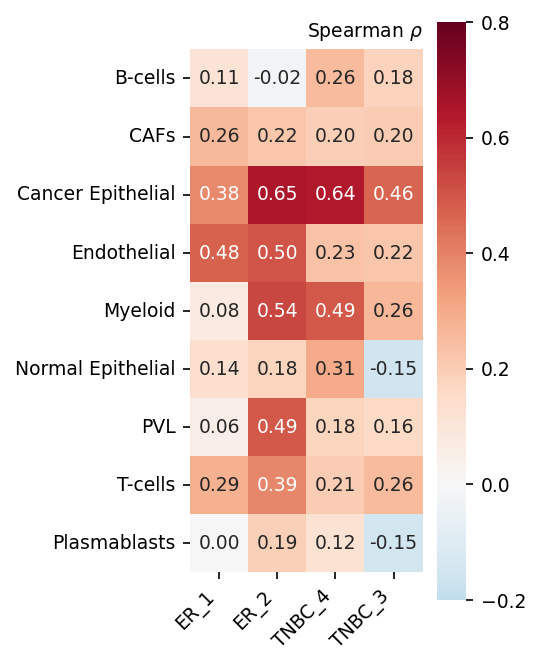

In [16]:
plt.figure(figsize=(figsize, figsize*2), dpi=dpi)
plt.rc('font', size=fontsize)
ax = sns.heatmap(df_corr.T, cmap="RdBu_r", center=0, annot=True, square=True, vmax=0.8, vmin=-0.2, fmt='.2f')
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.title(r'Spearman $\rho$', fontsize=fontsize, loc='right')
# plt.title(r'Pearson r', fontsize=fontsize, loc='right')

Text(1.0, 1.0, 'Spearman $\\rho$')

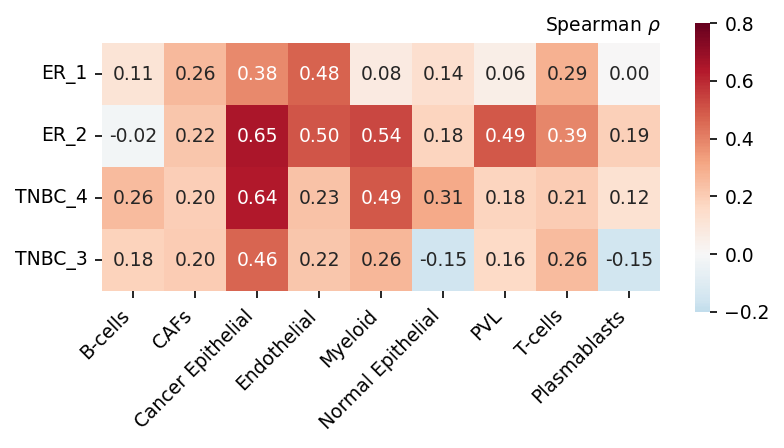

In [17]:
plt.figure(figsize=(figsize*2.4, figsize), dpi=dpi)
plt.rc('font', size=fontsize)
ax = sns.heatmap(df_corr, cmap="RdBu_r", center=0, annot=True, square=True, vmax=0.8, vmin=-0.2, fmt='.2f')
ax.set_xlabel("")
ax.set_ylabel("")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.title(r'Spearman $\rho$', fontsize=fontsize, loc='right')
# plt.title(r'Pearson r', fontsize=fontsize, loc='right')